## Housing Prices

* https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

### Explore

In [68]:
train_df = pd.read_csv('../data/train_housing.csv')

In [69]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [70]:
# Inspect the target
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

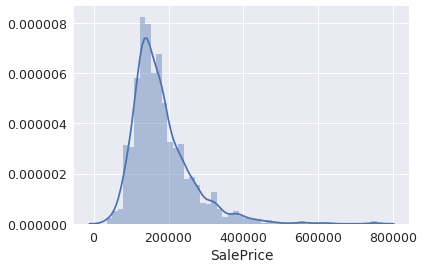

In [71]:
# Plot histogram
sns.distplot(train_df['SalePrice'])

* Deviate from the normal distribution.
* Have positive skewness.
* Show peakedness

### Skewness and kurtosis

In [72]:
# Skew = measure of symmetry
# Kurtosis = How 'peaky' or 'flat' the distribution is
print("Skewness: ", train_df['SalePrice'].skew())
print("Kurtosis: ", train_df['SalePrice'].kurt())

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


Skewness

![](http://s3.thingpic.com/images/KW/GA7Q8fXFwKJXVdtbBEwuEisB.jpeg)

Kurtosis

![](http://www.janzengroup.net/stats/images/skewkurt.JPG)

### Correlation Matrix

* Shows how correlated different features are with each other
* If two features are very highly correlated, we can discard one
* Multicollinearity = one feature can be linearly predicted from others

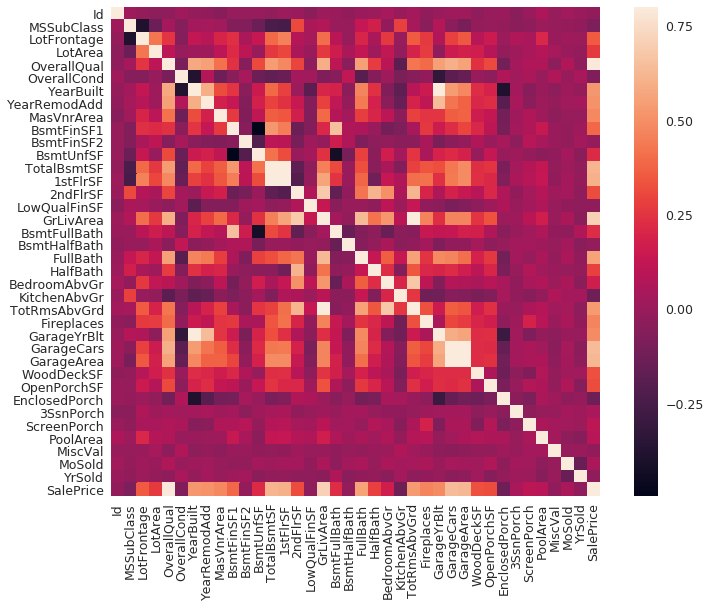

In [73]:
# Feature-to-Feature Correlation
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

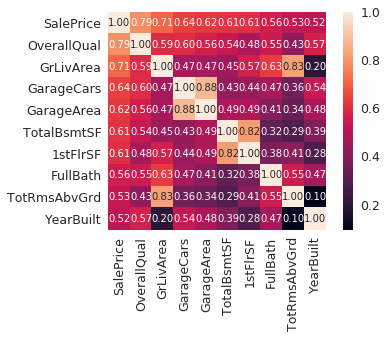

In [74]:
# Feature-to-Target Correlation
k = 10 # number of variables for heatmap

# Get the variables most correlated with SalesPrice
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

# Get the Correlation Coefficients
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Seaborn Pair Plot

Quickly visualize the relationships between features

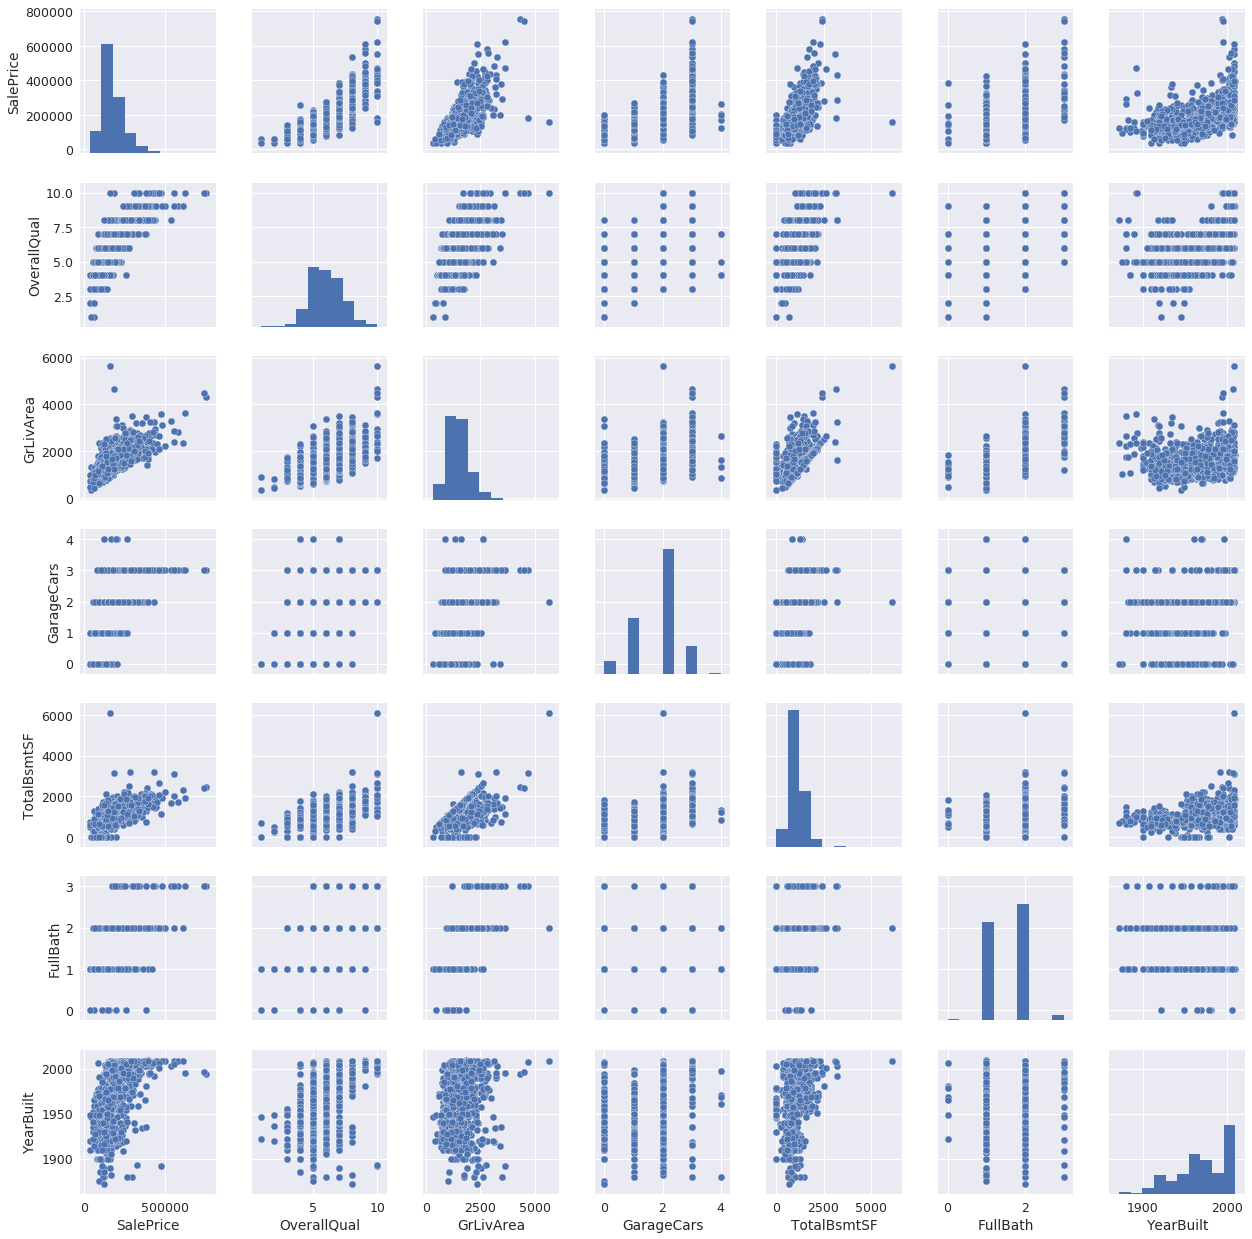

In [75]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 
        'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

### Missing Data

In [76]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [77]:
# Remove data with more than 15% missing

#dealing with missing data
train_df = train_df.drop((missing_data[missing_data['Total'] > 1]).index,1)
train_df = train_df.drop(train_df.loc[train_df['Electrical'].isnull()].index)
train_df.isnull().sum().max() #just checking that there's no missing data missing...

0

### Outliers

In [78]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
# Mean = 0, Std = 1
saleprice_scaled = StandardScaler().fit_transform(train_df['SalePrice'][:,np.newaxis]);

low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


/home/bfortuner/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [79]:
#deleting points
train_df.sort_values(by = 'GrLivArea', ascending = False)[:2]
train_df = train_df.drop(train_df[train_df['Id'] == 1299].index)
train_df = train_df.drop(train_df[train_df['Id'] == 524].index)

### Statistical Assumptions

Normality

When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

Homoscedasticity

I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

Linearity

The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

Absence of correlated errors

Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

### Normality

* If data is NOT normal, we can transform it!
* In case of positive skewness, log transformations usually works well
* Several statistical tests (t-statistics) assume normality

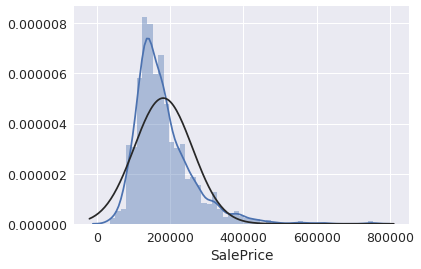

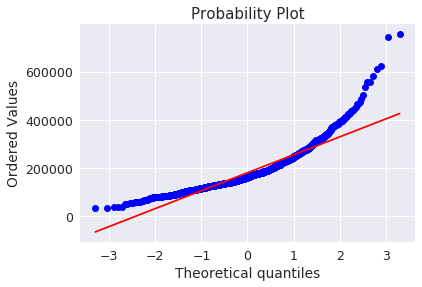

In [80]:
import scipy
from scipy.stats import norm

## Test for Normality
sns.distplot(train_df['SalePrice'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(train_df['SalePrice'], plot=plt)

In [81]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])

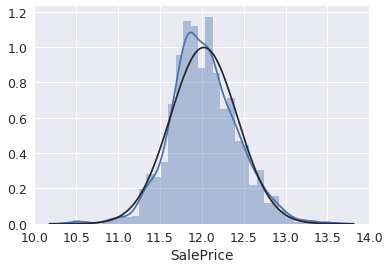

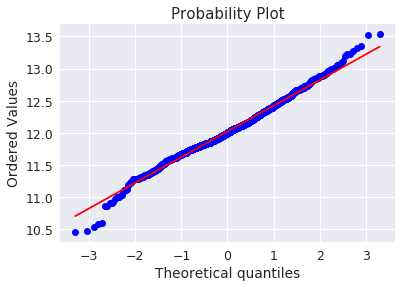

In [82]:
#transformed histogram and normal probability plot
sns.distplot(train_df['SalePrice'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(train_df['SalePrice'], plot=plt)

### Homoscedasticity

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

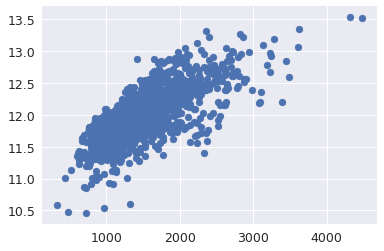

In [83]:
plt.scatter(train_df['GrLivArea'], train_df['SalePrice']);

### One-hot encoding

In [84]:
#convert categorical variable into dummy
train_df = pd.get_dummies(train_df)

### Scikit Train/Val Split

In [85]:
from sklearn.cross_validation import cross_val_score

train_df = train_df.drop(columns=['Id'])

In [88]:
columns = [c for c in train_df.columns if c not in ['Id','SalePrice']]

In [89]:
y = train_df['SalePrice']
X = train_df[columns]

### Model

In [90]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
train_df['pred'] = model.predict(X)

### Evaluate

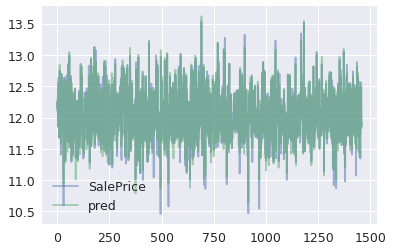

In [91]:
train_df[['SalePrice', 'pred']].plot(alpha=0.5);

In [92]:
model.score(X,y)

0.943746691403352

In [96]:
params = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
params

RoofStyle_Shed           0.357800
RoofMatl_Membran         0.311895
Condition2_PosA          0.219511
Functional_Typ           0.151544
Heating_Wall             0.140505
Condition2_Feedr         0.126427
Exterior2nd_CmentBd      0.122497
Neighborhood_StoneBr     0.121548
Foundation_Stone         0.119774
Neighborhood_Crawfor     0.113717
Functional_Min1          0.105738
Functional_Min2          0.104840
MSZoning_FV              0.104117
Exterior1st_BrkFace      0.102962
Utilities_AllPub         0.099782
Electrical_Mix           0.098506
RoofMatl_Metal           0.095045
Condition2_Norm          0.090793
MSZoning_RL              0.090264
SaleType_ConLD           0.083991
MSZoning_RH              0.083547
Heating_GasW             0.080873
LandSlope_Mod            0.075772
Neighborhood_NridgHt     0.071827
Functional_Maj1          0.071361
Street_Pave              0.067733
Exterior1st_MetalSd      0.066600
SaleCondition_AdjLand    0.065886
SaleType_New             0.063507
Exterior1st_St

### Cross-Validation

In [98]:
from sklearn.cross_validation import cross_val_score

cross_val_score(model, X, y, cv=10)

array([0.91094267, 0.92496531, 0.9139953 , 0.89479231, 0.89951641,
       0.91777954, 0.90224701, 0.92819725, 0.93077514, 0.89851971])